## Machine Learning for predicting Avalanche Danger Levels


In [2]:
#Defining some functions
def apr(y_pred, y_real):

    class_difference = (y_pred - y_real)
    class_difference_df = pd.DataFrame({'y_pred': y_pred, 'y_real': y_real, 'abs_difference': class_difference})
    # Define weights based on the class difference
    weights = [5 if diff >= 2 else (2 if diff < 0 else 1) for diff in class_difference]
    
    accuracy = metrics.accuracy_score(y_real, y_pred)
    precision = metrics.precision_score(y_real, y_pred,average='weighted', sample_weight=weights)
    recall = metrics.recall_score(y_real, y_pred,average='weighted', sample_weight=weights)
    f1 = metrics.f1_score(y_real, y_pred,average='weighted',sample_weight=weights)
    
    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")
    return accuracy, precision, recall, f1

def apr2(y_pred, y_real):

    class_difference = (y_pred - y_real)
    class_difference_df = pd.DataFrame({'y_pred': y_pred, 'y_real': y_real, 'abs_difference': class_difference})
    weights = [5 if diff >= 2 else (2 if diff < 0 else 1) for diff in class_difference]
    
    accuracy = metrics.accuracy_score(y_real, y_pred)
    precision = metrics.precision_score(y_real, y_pred,average='micro', sample_weight=weights)
    recall = metrics.recall_score(y_real, y_pred,average='micro', sample_weight=weights)
    f1 = metrics.f1_score(y_real, y_pred,average='micro',sample_weight=weights)
    
    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")
    return accuracy, precision, recall, f1

def produce_confusion(positive_label:str, negative_label:str, cut_off, df, y_pred_name, y_real_name):
     
    if cut_off != 'binary':      
        df['pred_binary'] = np.where(df[y_pred_name] > cut_off , 1, 0)
    else: 
        df['pred_binary'] = df[y_pred_name]
    
    #Build the CM
    cm = confusion_matrix(df[y_real_name], df['pred_binary'])  
    
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g'); 

    # labels, title, ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('Real labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels([negative_label, positive_label])
    ax.yaxis.set_ticklabels([negative_label, positive_label]);

    print('Test accuracy = ', accuracy_score(df[y_real_name], df['pred_binary']))

    return accuracy_score(df[y_real_name], df['pred_binary'])

## 1. Decision Tree Algorithm

In [3]:
df = pd.read_csv("avalanche_data.csv")

In [4]:
df.drop(columns=['set','TS4_mean', 'TS3_mean','MS_Soil_Runoff_mean','mAlbedo_mean','Qg_mean'], inplace = True)

In [ ]:
df.info()

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
feature_cols = list(df.columns)
feature_cols.remove('dangerLevel')

In [8]:
X = df[feature_cols]
y = df['dangerLevel']

In [ ]:
sns.displot(df['dangerLevel'])
plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [11]:
train = X_train

In [12]:
train = pd.concat([X_train, y_train], axis=1)

In [13]:
train.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)

In [14]:
dt = DecisionTreeClassifier()

In [15]:
train.dropna(inplace=True)

In [16]:
X_train = train.drop(columns = ['ID','datum','station_code','dangerLevel'])

In [17]:
feature_cols = list(X_train.columns)

In [18]:
y_train = train['dangerLevel']

In [ ]:
dt.fit(X_train, y_train)

In [20]:
grid = GridSearchCV(estimator = DecisionTreeClassifier(),
                    param_grid = {'max_depth': [ 10, 26,40],
                                  'min_samples_split': [1,10,3,5],
                                  'min_samples_leaf': [ 10, 12, 20],
                                  'max_features':[26,10,7]},
                    cv = 10,
                    refit = True,
                    verbose = 2,
                    scoring = 'accuracy')

In [ ]:
try:
    grid.fit(X_train, y_train)
except:
    print("Grid incomplete")

In [22]:
try:
    print(grid.best_estimator_)
except:
    print("Grid incomplete")

DecisionTreeClassifier(max_depth=10, max_features=26, min_samples_leaf=10,
                       min_samples_split=10)


In [23]:
dt = DecisionTreeClassifier(max_depth=10, max_features=26, min_samples_leaf=10,
                       min_samples_split=10)

In [ ]:
dt.fit(X_train, y_train)

In [25]:
importance = list(zip(feature_cols, list(dt.feature_importances_)))

In [26]:
filtered_importance = [(name, value) for name, value in importance if value > 0.01]

In [27]:
filtered_importance

[('elevation_th', 0.22624494782502255),
 ('warnreg', 0.01410469484715828),
 ('VW', 0.012057077243624592),
 ('wind_trans24', 0.012548393006966327),
 ('wind_trans24_3d', 0.02639340269600774),
 ('HN24', 0.09695737452627455),
 ('HN72_24', 0.03335717473027052),
 ('HN24_7d', 0.06382649146572211),
 ('Pen_depth', 0.29729790642901094),
 ('min_ccl_pen', 0.05751266573838051)]

In [28]:
important_columns = [item[0] for item in filtered_importance]

X_train2 = X_train[[col for col in X_train.columns if col in important_columns]]

In [29]:
grid = GridSearchCV(estimator = DecisionTreeClassifier(),
                    param_grid = {'max_depth': [ 5, 10, 15],
                                  'min_samples_split': [1,2,3,5],
                                  'min_samples_leaf': [ 6, 12, 24],
                                  'max_features':[26,10,7]},
                    cv = 10,
                    refit = True,
                    verbose = 2,
                    scoring = 'accuracy')

In [ ]:
try:
    grid.fit(X_train2, y_train)
except:
    print("Grid incomplete")

In [31]:
try:
    print(grid.best_estimator_)
except:
    print("Grid incomplete")

DecisionTreeClassifier(max_depth=15, max_features=26, min_samples_leaf=24,
                       min_samples_split=3)


In [46]:
dt = DecisionTreeClassifier(max_depth=10, max_features=26, min_samples_leaf=12,
                       min_samples_split=3)

In [ ]:
dt.fit(X_train2, y_train)

In [48]:
train_results = X_train2.copy()
train_results['y_pred'] = dt.predict(X_train2)
train_results['y_real'] = y_train
train_results['y_prob'] = dt.predict_proba(X_train2)[:,1]

train_results

,elevation_th,warnreg,VW,wind_trans24,wind_trans24_3d,HN24,HN72_24,HN24_7d,Pen_depth,min_ccl_pen,y_pred,y_real,y_prob
9293,1500.0,17,0.3750,0.63125,14.90,0.000000,1.873500,8.59,18.290832,0.51,1,1,0.000000
8819,2100.0,17,1.8125,0.00000,41.59,0.000000,7.880625,77.49,21.927825,0.29,2,3,0.516746
10505,2000.0,18,2.0250,0.00000,57.78,0.000000,6.381875,43.98,17.193592,0.37,2,2,0.573529
7671,1500.0,16,4.7000,0.00000,0.00,0.000000,0.000000,18.96,14.242812,0.50,1,1,0.000000
2361,2000.0,15,1.6875,0.00000,0.00,0.000000,0.000000,10.22,16.614043,0.23,2,2,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,2000.0,19,1.5625,0.00000,0.00,0.000000,0.000000,0.00,10.085894,0.77,1,1,0.002157
5390,1900.0,16,5.4875,0.00000,0.00,22.706625,33.097625,84.31,22.839708,0.26,4,3,0.000000
860,1500.0,15,4.3375,0.18975,0.93,0.000000,0.000000,1.15,12.721856,0.63,1,1,0.000000
15795,1500.0,19,1.4000,0.00000,0.00,0.000000,0.000000,0.00,12.892082,0.64,1,1,0.000000


In [49]:
train_scores = apr(train_results['y_pred'], train_results['y_real'])

Accuracy:0.829747220532109
Precision:0.750956947030969
Recall:0.7437651841935644
F1:0.7380728545315868


In [36]:
test = X_test

In [37]:
test = pd.concat([X_test, y_test], axis=1)

In [38]:
test.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)

In [39]:
test.dropna(inplace=True)

In [40]:
X_test = test.drop(columns = ['ID','datum','station_code','dangerLevel'])

In [41]:
X_test2 = X_test[[col for col in X_test.columns if col in important_columns]]

In [42]:
y_test = test['dangerLevel']

In [51]:
test_results = X_test2.copy()
test_results['y_pred'] = dt.predict(X_test2)
test_results['y_real'] = y_test
test_results['y_prob'] = dt.predict_proba(X_test2)[:,1]

test_results

,elevation_th,warnreg,VW,wind_trans24,wind_trans24_3d,HN24,HN72_24,HN24_7d,Pen_depth,min_ccl_pen,y_pred,y_real,y_prob
15654,2400.0,19,3.9625,118.136375,154.77,0.00000,0.626250,17.33,18.935396,0.42,3,3,0.111111
13625,2200.0,19,1.2000,0.876000,5.14,0.00000,8.543750,23.75,19.260345,0.36,2,2,0.743738
26939,2000.0,20,2.0125,0.000000,0.00,0.00000,0.000000,0.00,7.950065,1.60,1,1,0.002157
2201,1800.0,15,2.1125,0.000000,34.30,0.00000,11.328000,24.48,19.281109,0.26,2,2,0.573529
13529,1500.0,19,2.4375,0.000000,2.71,0.00000,0.000000,6.59,16.479940,0.45,1,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1350,1500.0,15,1.2625,0.000000,0.00,0.00000,0.000000,1.00,15.828622,0.29,1,1,0.000000
13989,2000.0,19,0.7625,0.000000,29.18,0.00000,31.557625,66.27,19.954292,0.37,2,2,0.466667
16113,2200.0,19,7.1625,1.483000,21.22,0.98750,7.041750,30.43,17.005411,0.37,3,2,0.185185
17542,1900.0,19,1.6000,26.253500,126.86,6.07275,35.517625,65.53,28.729350,0.15,3,4,0.044444


In [52]:
test_scores = apr(test_results['y_pred'], test_results['y_real'])

Accuracy:0.7926073483842409
Precision:0.7013558228973341
Recall:0.6973709834469328
F1:0.6879395997004338


In [53]:
print(f'Score on training set: {dt.score(X_train2, y_train)}')
print(f'Score on testing set: {dt.score(X_test2, y_test)}')

Score on training set: 0.829747220532109
Score on testing set: 0.7926073483842409


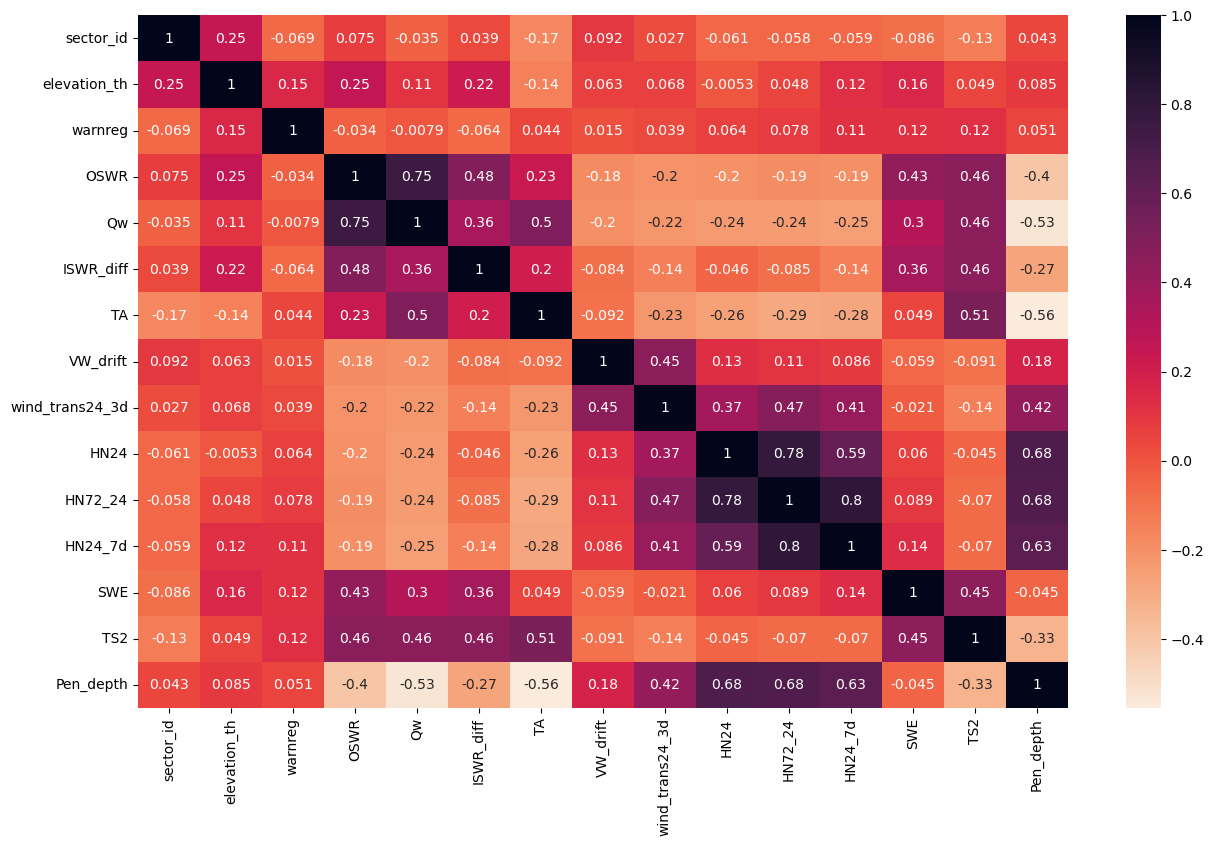

In [44]:
plt.figure(figsize=(15,9))
sns.heatmap(X_train2.corr(numeric_only=True), annot=True, cmap='rocket_r')
plt.show()

# 2.Random Forest Fitting

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train2, y_train)

In [46]:
train_results = X_train.copy()
train_results['y_pred'] = rfc.predict(X_train2)
train_results['y_real'] = y_train
train_results['y_prob'] = rfc.predict_proba(X_train2)[:,1]

In [47]:
train_scores = apr(train_results['y_pred'], train_results['y_real'])

Accuracy:1.0
Precision:1.0
Recall:1.0
F1:1.0


In [48]:
test_results = X_test2.copy()
test_results['y_pred'] = rfc.predict(X_test2)
test_results['y_real'] = y_test
test_results['y_prob'] = rfc.predict_proba(X_test2)[:,1]

test_results

,sector_id,elevation_th,warnreg,OSWR,Qw,ISWR_diff,TA,VW_drift,wind_trans24_3d,HN24,HN72_24,HN24_7d,SWE,TS2,Pen_depth,y_pred,y_real,y_prob
15654,4211,2400.0,19,179.500,28.384000,34.745000,-7.1000,15.204000,154.77,0.00000,0.626250,17.33,570.676375,-5.4625,18.935396,3,3,0.43
13625,4124,2200.0,19,203.250,31.236750,36.378000,-7.8125,2.789625,5.14,0.00000,8.543750,23.75,590.127750,-3.3125,19.260345,2,2,0.90
26939,4222,2000.0,20,242.125,120.519875,63.524000,1.1625,2.357500,0.00,0.00000,0.000000,0.00,685.210625,0.0000,7.950065,1,1,0.00
2201,7114,1800.0,15,95.500,20.247375,19.826250,-7.4875,5.080000,34.30,0.00000,11.328000,24.48,156.941500,-10.0750,19.281109,3,2,0.40
13529,7123,1500.0,19,135.875,25.249125,43.287750,-6.8875,5.937500,2.71,0.00000,0.000000,6.59,301.106500,-6.6625,16.479940,1,1,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1350,4124,1500.0,15,80.125,10.367500,17.274250,-6.2125,2.773500,0.00,0.00000,0.000000,1.00,210.214625,-10.5625,15.828622,1,1,0.01
13989,1312,2000.0,19,161.500,19.400125,90.401500,-5.4375,2.073500,29.18,0.00000,31.557625,66.27,396.605000,-4.6125,19.954292,3,2,0.37
16113,4232,2200.0,19,81.000,19.850000,27.651375,-1.8250,2.722500,21.22,0.98750,7.041750,30.43,1250.965750,-4.0000,17.005411,2,2,0.73
17542,4222,1900.0,19,69.375,7.708250,30.414625,-12.0875,4.036375,126.86,6.07275,35.517625,65.53,184.886375,-14.4625,28.729350,3,4,0.01


In [49]:
test_scores = apr(test_results['y_pred'], test_results['y_real'])

Accuracy:0.8490482514386897
Precision:0.7773525145598843
Recall:0.7762039660056658
F1:0.7648841083971479


As expected the results were extremely overfit, producing little valuable information. 

# 3.Logistic Regression Analysis

In [50]:
feature_cols = list(df.columns)
feature_cols.remove('dangerLevel')

In [51]:
bad_columns = ['zS5','zS4','zSd_mean','sector_id','elevation_station','MS_Evap','MS_Sublimation',
              'MS_SN_Runoff', 'MS_Rain',
              'Qr','zSn','ISWR',
              'zSs',
              'min_ccl_pen', 'ILWR','sk38_pwl','ccl_pwl_100','sn38_pwl']
feature_cols = [col for col in feature_cols if col not in bad_columns]

In [52]:
X = df[feature_cols]
y = df['dangerLevel']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [54]:
train = X_train

In [55]:
train = pd.concat([X_train, y_train], axis=1)

In [56]:
train.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)

In [57]:
train.dropna(inplace=True)

In [58]:
X_train = train.drop(columns = ['ID','datum','station_code','dangerLevel'])

In [59]:
feature_cols = list(X_train.columns)

In [60]:
y_train = train['dangerLevel']

In [61]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 100000000)

In [ ]:
lr.fit(X_train, y_train)

In [63]:
lr.predict_proba(X_train)

array([[9.42185395e-01, 4.77077013e-02, 9.79071830e-03, 3.16181534e-04,
        4.22837872e-09],
       [2.02891504e-06, 6.27259541e-01, 3.59077885e-01, 1.36603710e-02,
        1.74608982e-07],
       [1.33374014e-04, 7.63227237e-01, 2.33750004e-01, 2.88913223e-03,
        2.52190630e-07],
       ...,
       [9.99660681e-01, 3.08437196e-04, 2.79432760e-05, 2.93844617e-06,
        8.02114987e-17],
       [9.99490474e-01, 4.82949740e-04, 2.62868387e-05, 2.89028848e-07,
        5.52968732e-16],
       [6.27114115e-02, 8.56053557e-01, 8.08027596e-02, 4.31031923e-04,
        1.24021704e-06]])

In [64]:
X_train[['prob_1', 'prob_2', 'prob_3','prob_4','prob_5']] = lr.predict_proba(X_train)

In [65]:
X_train['y_pred'] =  np.where(X_train['prob_5'] > 0.01, 5,
                               np.where(X_train['prob_4'] > 0.3, 4,
                                        np.where(X_train['prob_3'] > 0.5, 3, 
                                                np.where(X_train['prob_2'] > 0.6, 2,
                                                         np.where(X_train['prob_1'] > 0.4, 1,3)))))

In [66]:
highest_prob_column = X_train[['prob_1', 'prob_2', 'prob_3', 'prob_4', 'prob_5']].idxmax(axis=1)

In [67]:
highest_prob_column

9293     prob_1
8819     prob_2
10505    prob_2
7671     prob_1
2361     prob_1
          ...  
21575    prob_1
5390     prob_3
860      prob_1
15795    prob_1
23654    prob_2
Length: 18084, dtype: object

In [68]:
values = [1, 2, 3, 4, 5]

In [69]:
X_train['y_pred'] = np.select([highest_prob_column == 'prob_1', 
                                highest_prob_column == 'prob_2', 
                                highest_prob_column == 'prob_3', 
                                highest_prob_column == 'prob_4', 
                                highest_prob_column == 'prob_5'], 
                               values, 
                               default=3)

In [70]:
print(metrics.confusion_matrix(y_train, X_train['y_pred']))

[[5347  167   23    0    0]
 [ 238 4520  970    2    0]
 [  55 1280 4537  116    1]
 [   3   27  525  212   10]
 [   0    0   16    5   30]]


In [71]:
X_train['y_pred'].value_counts()

y_pred
3    6071
2    5994
1    5643
4     335
5      41
Name: count, dtype: int64

In [72]:
def get_results(actual, predicted):
    print("The confusion matrix for your predictions is:")
    print(metrics.confusion_matrix(actual, predicted), "\n")
    print(f"The accuracy of your model is: {metrics.accuracy_score(actual, predicted)}")
    print(f"The recall of your model is: {metrics.recall_score(actual, predicted,average='macro')}")
    print(f"The precision of your model is: {metrics.precision_score(actual, predicted,average='macro')}")
    print(f"The F1-score of your model is: {metrics.f1_score(actual, predicted,average='macro')}")

In [73]:
get_results(y_train, X_train['y_pred'])

The confusion matrix for your predictions is:
[[5347  167   23    0    0]
 [ 238 4520  970    2    0]
 [  55 1280 4537  116    1]
 [   3   27  525  212   10]
 [   0    0   16    5   30]] 

The accuracy of your model is: 0.8098871930988719
The recall of your model is: 0.6746302380289253
The precision of your model is: 0.7626999061900062
The F1-score of your model is: 0.7026941864865437
